In [20]:
from meteostat import Point, Hourly
from datetime import datetime
import pandas as pd

# Set time period
start_date = datetime(2024, 1, 1)
now = datetime.now()
end_date = datetime(now.year, now.month, now.day)

# Create Point (Phuket, Thailand)
location = Point(7.8804, 98.3923, 70) #lat, long, altitude (optional)

# Get hourly data
hourly = Hourly(location, start_date, end_date)
hourly = pd.DataFrame(hourly.fetch())
# Delete columns with missing values
hourly = hourly.dropna(axis=1, how='any')


In [21]:
hourly

,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
time,,,,,,,,
2024-01-01 00:00:00,25.9,23.9,89.0,0.0,0.0,0.0,1010.4,2.0
2024-01-01 01:00:00,27.6,24.0,81.0,0.0,71.0,1.8,1011.3,2.0
2024-01-01 02:00:00,28.9,24.0,75.0,0.0,71.0,3.7,1011.8,2.0
2024-01-01 03:00:00,29.6,24.0,72.0,0.0,0.0,0.0,1012.2,2.0
2024-01-01 04:00:00,30.6,24.0,68.0,0.0,72.0,1.8,1011.7,2.0
...,...,...,...,...,...,...,...,...
2024-04-09 20:00:00,29.1,24.6,77.0,0.0,297.0,0.0,1008.5,2.0
2024-04-09 21:00:00,28.8,24.6,78.0,0.0,297.0,0.0,1008.2,2.0
2024-04-09 22:00:00,28.8,24.6,78.0,0.0,82.0,0.0,1008.6,2.0


In [22]:
from typing import Tuple
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor


# Функция для получения данных о погоде в заданном месте в заданный период
def get_weather_data(lat: float, lon: float, alt:  float=0,  start_date: datetime=datetime.now(), end_date: datetime=datetime.now()) -> pd.DataFrame:
    """
    Get weather data for the specified location in the specified period
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param alt: Altitude of the location (optional)
    :param start_date: Beginning of the period
    :param end_date: End of the period
    :return: DataFrame with weather data
    """
    # Create Point
    location = Point(lat, lon, alt)
    # Get hourly data
    hourly = Hourly(location, start_date, end_date)
    hourly = pd.DataFrame(hourly.fetch())
    # Delete columns with missing values
    hourly = hourly.dropna(axis=1, how='any')
    return hourly

# Функция разделения данных на обучающую и тестовую выборки
def split_data(data: pd.DataFrame, test_size: float=0.3) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split data into training and test sets
    :param data: DataFrame with data
    :param test_size: The proportion of the dataset to include in the test split
    :return: Training and test sets
    """
    # Split data
    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    return train, test

# Функция для создания признаков
def create_features(data: pd.DataFrame, target: str, lags: int=1) -> pd.DataFrame:
    """
    Create features for machine learning
    :param data: DataFrame with data
    :param target: Target variable
    :param lags: Number of lagged values
    :return: DataFrame with features
    """
    # Create lagged values
    for lag in range(1, lags + 1):
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)
    return data

In [26]:
# Set time period
start_date = datetime(2024, 1, 1)
now = datetime.now()
end_date = datetime(now.year, now.month, now.day)
# Get weather data
data = get_weather_data(7.8804, 98.3923, 70, start_date, end_date)
# Split data
train, test = split_data(data)

In [28]:
target = 'rhum'

In [29]:
# Data preprocessing
train = create_features(train, target, lags=24)
test = create_features(test, target, lags=24)

# Drop rows with missing values
train = train.dropna()
test = test.dropna()

# Features and target variable
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [30]:
|# Create CatBoost model
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=100)
# Fit model
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)

0:	learn: 9.7701042	total: 136ms	remaining: 2m 15s
100:	learn: 0.8163551	total: 241ms	remaining: 2.15s
200:	learn: 0.4224448	total: 376ms	remaining: 1.5s
300:	learn: 0.2915871	total: 488ms	remaining: 1.13s
400:	learn: 0.2219919	total: 603ms	remaining: 901ms
500:	learn: 0.1810843	total: 716ms	remaining: 713ms
600:	learn: 0.1484965	total: 822ms	remaining: 546ms
700:	learn: 0.1248828	total: 928ms	remaining: 396ms
800:	learn: 0.1058603	total: 1.03s	remaining: 256ms
900:	learn: 0.0908999	total: 1.14s	remaining: 125ms
999:	learn: 0.0775042	total: 1.23s	remaining: 0us


In [33]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.6437039719642316

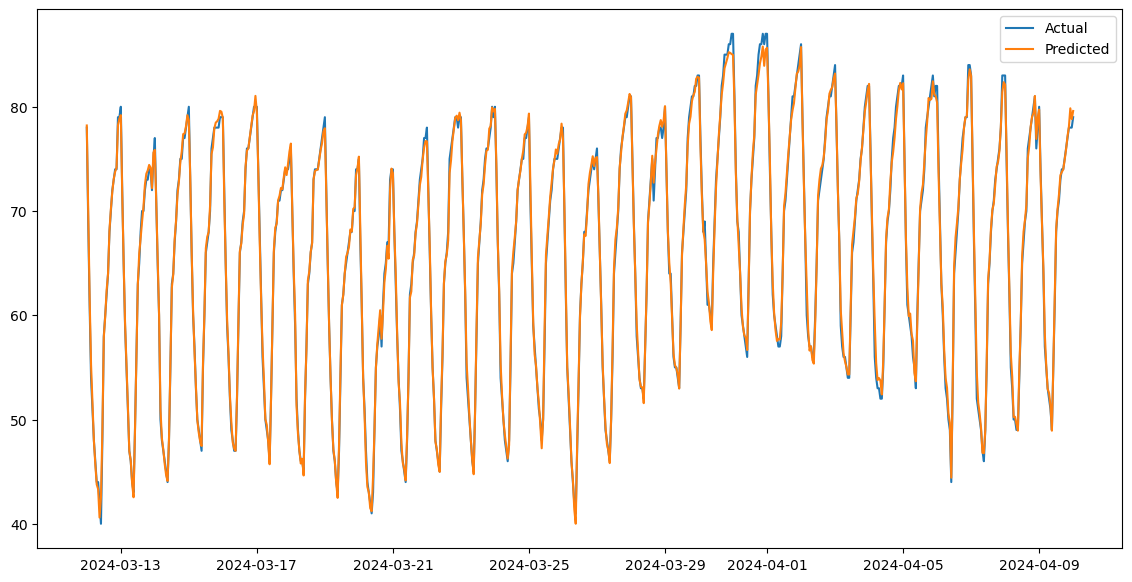

In [34]:
import matplotlib.pyplot as plt

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [36]:
# Model hyperparameters tuning
from sklearn.model_selection import GridSearchCV

# Create CatBoost model
model = CatBoostRegressor(loss_function='RMSE', verbose=100)

# Grid of hyperparameters
param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 1],
    'depth': [4, 6, 8]
}

# Grid search
grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Best hyperparameters
grid.best_params_

0:	learn: 10.4885022	total: 787us	remaining: 77.9ms
99:	learn: 5.1965632	total: 54.2ms	remaining: 0us
0:	learn: 10.5409185	total: 760us	remaining: 75.3ms
99:	learn: 5.2344697	total: 55ms	remaining: 0us
0:	learn: 10.4244536	total: 736us	remaining: 73ms
99:	learn: 5.1868468	total: 61.8ms	remaining: 0us
0:	learn: 9.7419172	total: 1.11ms	remaining: 110ms
99:	learn: 1.1789152	total: 61.9ms	remaining: 0us
0:	learn: 9.7599661	total: 682us	remaining: 67.5ms
99:	learn: 0.9096584	total: 53.1ms	remaining: 0us
0:	learn: 9.6366255	total: 4.3ms	remaining: 426ms
99:	learn: 0.9586271	total: 53ms	remaining: 0us
0:	learn: 4.5914073	total: 769us	remaining: 76.2ms
99:	learn: 0.3139398	total: 53.9ms	remaining: 0us
0:	learn: 4.2279941	total: 768us	remaining: 76.1ms
99:	learn: 0.2791600	total: 53.8ms	remaining: 0us
0:	learn: 3.9422690	total: 714us	remaining: 70.7ms
99:	learn: 0.2669025	total: 51.1ms	remaining: 0us
0:	learn: 10.4885022	total: 719us	remaining: 359ms
100:	learn: 5.1603316	total: 54ms	remaining:

{'depth': 4, 'iterations': 1000, 'learning_rate': 0.1}

In [37]:
# Fit model with best hyperparameters
model = CatBoostRegressor(iterations=grid.best_params_['iterations'],
                          learning_rate=grid.best_params_['learning_rate'],
                          depth=grid.best_params_['depth'],
                          loss_function='RMSE',
                          verbose=100)
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0:	learn: 9.8038079	total: 922us	remaining: 921ms
100:	learn: 0.9795369	total: 61.7ms	remaining: 550ms
200:	learn: 0.5641715	total: 119ms	remaining: 474ms
300:	learn: 0.4017841	total: 178ms	remaining: 414ms
400:	learn: 0.3133704	total: 239ms	remaining: 356ms
500:	learn: 0.2605383	total: 304ms	remaining: 303ms
600:	learn: 0.2237651	total: 371ms	remaining: 246ms
700:	learn: 0.1979162	total: 443ms	remaining: 189ms
800:	learn: 0.1760193	total: 510ms	remaining: 127ms
900:	learn: 0.1591446	total: 579ms	remaining: 63.6ms
999:	learn: 0.1445716	total: 637ms	remaining: 0us


0.5157224326628825

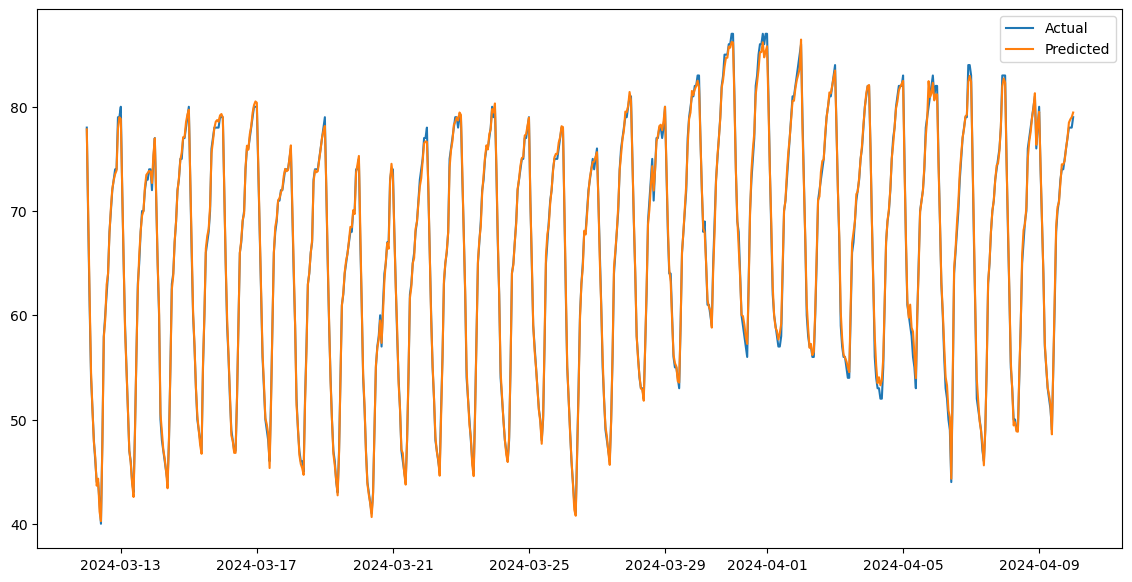

In [38]:
# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()
